# --------------------------
# Instalação de Dependências
# --------------------------

In [1]:
!git clone https://github.com/eduardobatista/ActVibModules.git

%pip install matplotlib
%pip install numpy
%pip install scikit-learn
%pip install scipy
%pip install pyarrow

fatal: destination path 'ActVibModules' already exists and is not an empty directory.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# ------------------
# Importações
# ------------------

In [2]:
import os
import gdown
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.neural_network import MLPClassifier
from ActVibModules.ActVibSystem import ActVibData 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -------------------
# Configuração de Path
# -------------------

In [3]:
os.getcwd()

'c:\\Users\\jpsfb\\OneDrive\\Área de Trabalho\\LINSE\\Códigos'

# -----------------------------------
# Download e Leitura dos Dados
# -----------------------------------

In [4]:
# Lista de tuplas contendo o ID do arquivo e o URL de cada arquivo
arquivos_para_baixar = [
    ('MedicaoDEDOjoao', 'https://drive.google.com/file/d/1waQTn6e9-QB5OPWqSTHl4HRZRisL7-rv/view?usp=drive_link'),
    ('MedicaoMETAL2joao', 'https://drive.google.com/file/d/19XDZhFSeum3GM6W2bq2fSOLUs0C-DO5d/view?usp=drive_link'),
    ('MedicaoMetalJOAO', 'https://drive.google.com/file/d/1B-3I_9Dd6cGZ2ccoiEbdP8B-pa4gZZKy/view?usp=drive_link'),
    ('MedicoesDedo2joao', 'https://drive.google.com/file/d/1HV1VR9SBKw7eI1yAJ33VNADVXSZVe_mV/view?usp=drive_link'),
    ('Dados_Impacto_Amortecido.feather', 'https://drive.google.com/file/d/1OlG9XfdQwxlVRHushhaP-SRYaKKO_D0n/view?usp=drive_link'),
    ('Dados_Impacto_Metalico.feather', 'https://drive.google.com/file/d/1mFfjhsMNsKoNTp-kmEL6gcK_tzwh8StB/view?usp=drive_link')
]

# Itera sobre cada tupla e baixa o arquivo correspondente
for arquivo_id, arquivo_url in arquivos_para_baixar:
    # Baixando o arquivo
    gdown.download(arquivo_url, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1waQTn6e9-QB5OPWqSTHl4HRZRisL7-rv
To: c:\Users\jpsfb\OneDrive\Área de Trabalho\LINSE\Códigos\MedicaoDEDOjoao.feather
100%|██████████| 6.31M/6.31M [00:00<00:00, 11.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=19XDZhFSeum3GM6W2bq2fSOLUs0C-DO5d
To: c:\Users\jpsfb\OneDrive\Área de Trabalho\LINSE\Códigos\MedicaoMETAL2joao.feather
100%|██████████| 6.20M/6.20M [00:00<00:00, 12.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B-3I_9Dd6cGZ2ccoiEbdP8B-pa4gZZKy
To: c:\Users\jpsfb\OneDrive\Área de Trabalho\LINSE\Códigos\MedicaoMetalJOAO.feather
100%|██████████| 6.49M/6.49M [00:00<00:00, 11.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HV1VR9SBKw7eI1yAJ33VNADVXSZVe_mV
To: c:\Users\jpsfb\OneDrive\Área de Trabalho\LINSE\Códigos\MedicoesDedo2joao.feather
100%|██████████| 6.26M/6.26M [00:00<00:00, 11.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OlG9XfdQwxlVRHushhaP-SRYaKKO_D0n
To: c:\Users\jpsfb\On

# ----------------------------
# Leitura e Pré-processamento
# ----------------------------

In [5]:
dadosDedo = ActVibData("MedicaoDEDOjoao.feather")
dadosMetal = ActVibData("MedicaoMetalJOAO.feather")
dadosDedo2 = ActVibData("MedicoesDedo2joao.feather")
dadosMetal2 = ActVibData("MedicaoMETAL2joao.feather")
dadosImpactoAmortecido = ActVibData("Dados_Impacto_Amortecido.feather")
dadosImpactoMetalico = ActVibData("Dados_Impacto_Metalico.feather")

# ------------------------------------------
# Análise e Visualização dos Dados (Exemplo)
# ------------------------------------------

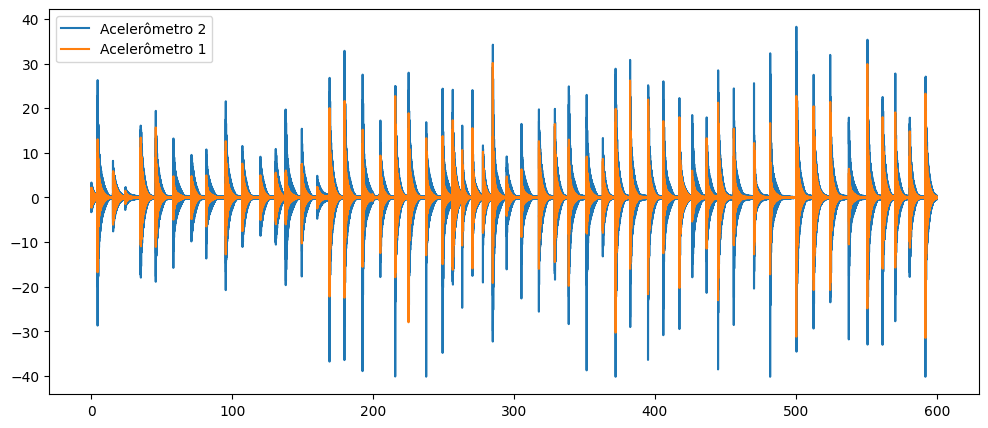

In [6]:
acc1d = dadosDedo.imu1accz.values - dadosDedo.imu1accz.mean()  
acc2d = dadosDedo.imu2accz.values - dadosDedo.imu2accz.mean()  
time1 = dadosDedo.time.values

plt.plot(time1,acc2d,label="Acelerômetro 2")
plt.plot(time1,acc1d,label="Acelerômetro 1")
plt.legend()
plt.gcf().set_size_inches(12,5)
plt.show()

# ---------------------------------------------------
# Pré-processamento e Detecção de Picos (Exemplo)
# ---------------------------------------------------

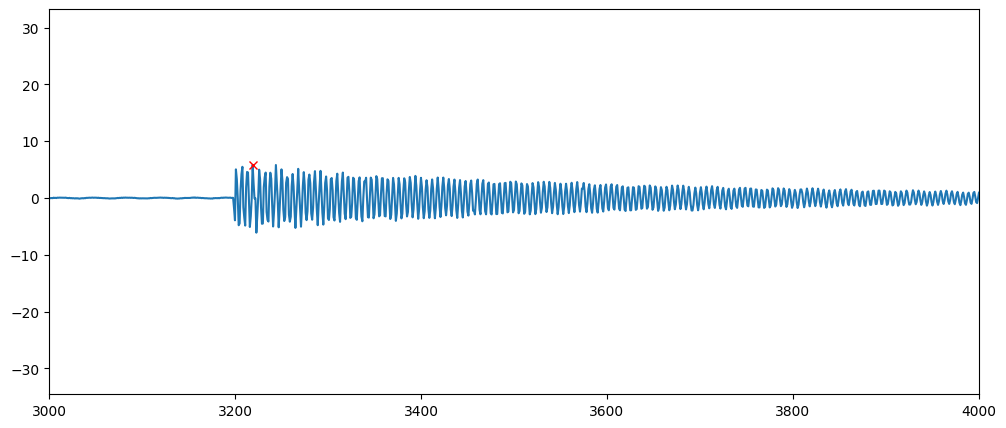

In [7]:
aux1 = signal.find_peaks(acc1d, height=3, distance=1300)
plt.plot(acc1d)
plt.plot(aux1[0], aux1[1]['peak_heights'], 'xr')
plt.xlim(3000, 4000)
plt.gcf().set_size_inches(12,5)
plt.show()

# ---------------------------------------------------
# Criação de Amostras e Rótulos
# ---------------------------------------------------

In [8]:
TamJanela = int(3.6 * 208)

def criar_amostras_e_rotulos(dados, nome_arquivo):
    acc1 = dados.imu1accz.values - dados.imu1accz.mean()
    picos, _ = signal.find_peaks(acc1, height=3, distance=1500)
    amostras = []
    rotulos = []

    for i in range(len(picos) - 1):
        inicio = picos[i]
        fim = picos[i] + TamJanela
        amostra = acc1[inicio:fim]
        amostra = amostra - amostra.mean() 
        amostra = amostra / amostra.max()
        amostras.append(amostra)
        rotulos.append(nome_arquivo)

    return amostras, rotulos

amostras_dedo, rotulos_dedo = criar_amostras_e_rotulos(dadosDedo, "MedicaoDEDOjoao.feather")
amostras_metal, rotulos_metal = criar_amostras_e_rotulos(dadosMetal, "MedicaoMetalJOAO.feather")
amostras_dedo2, rotulos_dedo2 = criar_amostras_e_rotulos(dadosDedo2, "MedicoesDedo2joao.feather")
amostras_metal2, rotulos_metal2 = criar_amostras_e_rotulos(dadosMetal2, "MedicaoMETAL2joao.feather")
amostras_impacto_amortecido, rotulos_impacto_amortecido = criar_amostras_e_rotulos(dadosImpactoAmortecido, "Dados_Impacto_Amortecido.feather")
amostras_impacto_metalico, rotulos_impacto_metalico = criar_amostras_e_rotulos(dadosImpactoMetalico, "Dados_Impacto_Metalico.feather")

# ---------------------------------------------------
# Empilhamento de Dados e Rótulos
# ---------------------------------------------------

In [16]:
X = np.vstack(amostras_dedo + amostras_metal + amostras_metal2 + amostras_dedo2 + amostras_impacto_amortecido + amostras_impacto_metalico)
y = np.array(rotulos_dedo + rotulos_metal + rotulos_metal2 + rotulos_dedo2 + rotulos_impacto_amortecido + rotulos_impacto_metalico)

# Codificação dos Rótulos
yenc = np.zeros(len(y), dtype=int)
for k, yy in enumerate(y):
    if "2" in yy.lower():
        yenc[k] = 0
    else:
        yenc[k] = 1

# TRECHO PARA TESTE: "2" = diferenciação entre vigas e "dedo" = diferenciação entre DEDO e METAL -> basta substituir para testar

# ---------------------------------------------------
# Visualização da Distribuição das Amostras
# ---------------------------------------------------

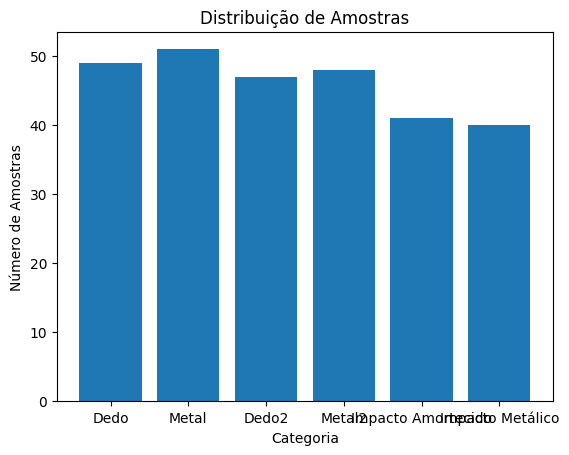

Amostras de dedo1: 49
Amostras de metal1: 51
Amostras de dedo2: 47
Amostras de metal2: 48

Tamanho de X: (276, 748)
Tamanho de y: (276,)


In [22]:
categorias = ['Dedo', 'Metal', 'Dedo2', 'Metal2', 'Impacto Amortecido', 'Impacto Metálico']
num_amostras = [len(amostras_dedo), len(amostras_metal), len(amostras_dedo2), len(amostras_metal2), len(amostras_impacto_amortecido), len(amostras_impacto_metalico)]

plt.bar(categorias, num_amostras)
plt.xlabel('Categoria')
plt.ylabel('Número de Amostras')
plt.title('Distribuição de Amostras')
plt.show()

print("Amostras de dedo1:", len(amostras_dedo))
print("Amostras de metal1:", len(amostras_metal))
print("Amostras de dedo2:", len(amostras_dedo2))
print("Amostras de metal2:", len(amostras_metal2))
print()
print("Tamanho de X:", X.shape)
print("Tamanho de y:", y.shape)

# ---------------------------------------------------
# Divisão dos Dados em Treino e Teste
# ---------------------------------------------------

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# ---------------------------------------------------
# Treinamento e Avaliação do Modelo Random Forest
# ---------------------------------------------------

In [19]:
model_rf = RandomForestClassifier(n_estimators=200)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Acurácia do modelo Random Forest: {accuracy_rf:.2f}')
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_true=y_test, y_pred=y_pred_rf))

Acurácia do modelo Random Forest: 0.93
                                  precision    recall  f1-score   support

Dados_Impacto_Amortecido.feather       1.00      0.91      0.95        11
  Dados_Impacto_Metalico.feather       1.00      1.00      1.00         7
         MedicaoDEDOjoao.feather       0.88      1.00      0.93         7
       MedicaoMETAL2joao.feather       1.00      0.82      0.90        11
        MedicaoMetalJOAO.feather       1.00      0.86      0.92         7
       MedicoesDedo2joao.feather       0.81      1.00      0.90        13

                        accuracy                           0.93        56
                       macro avg       0.95      0.93      0.93        56
                    weighted avg       0.94      0.93      0.93        56

[[10  0  0  0  0  1]
 [ 0  7  0  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  0  9  0  2]
 [ 0  0  1  0  6  0]
 [ 0  0  0  0  0 13]]


# ---------------------------------------------------
# Treinamento e Avaliação do Modelo MLP
# ---------------------------------------------------

In [20]:
model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f'Acurácia do modelo MLP: {accuracy_mlp:.2f}')
print(classification_report(y_test, y_pred_mlp))
print(confusion_matrix(y_true=y_test, y_pred=y_pred_mlp))

Acurácia do modelo MLP: 0.91
                                  precision    recall  f1-score   support

Dados_Impacto_Amortecido.feather       1.00      1.00      1.00        11
  Dados_Impacto_Metalico.feather       0.71      0.71      0.71         7
         MedicaoDEDOjoao.feather       1.00      1.00      1.00         7
       MedicaoMETAL2joao.feather       0.90      0.82      0.86        11
        MedicaoMetalJOAO.feather       1.00      0.86      0.92         7
       MedicoesDedo2joao.feather       0.87      1.00      0.93        13

                        accuracy                           0.91        56
                       macro avg       0.91      0.90      0.90        56
                    weighted avg       0.91      0.91      0.91        56

[[11  0  0  0  0  0]
 [ 0  5  0  1  0  1]
 [ 0  0  7  0  0  0]
 [ 0  1  0  9  0  1]
 [ 0  1  0  0  6  0]
 [ 0  0  0  0  0 13]]


# ---------------------------------------------------
# Avaliação da Variabilidade do Modelo
# ---------------------------------------------------

In [21]:
Resultados = []
n = 10
for k in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, yenc, test_size=0.2)
    model_rf = RandomForestClassifier(n_estimators=300)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    Resultados.append(accuracy_rf)

print()
print("Média da Acurácia (Random Forest):", np.array(Resultados).mean())
print("Variância da Acurácia (Random Forest):", np.array(Resultados).var())
print("Desvio Padrão da Acurácia (Random Forest):", np.array(Resultados).std())

Resultados = []
for k in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, yenc, test_size=0.2)
    model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
    model_mlp.fit(X_train, y_train)
    y_pred_mlp = model_mlp.predict(X_test)
    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    Resultados.append(accuracy_mlp)

print()
print("Média da Acurácia (MLP):", np.array(Resultados).mean())
print("Variância da Acurácia (MLP):", np.array(Resultados).var())
print("Desvio Padrão da Acurácia (MLP):", np.array(Resultados).std())


Média da Acurácia (Random Forest): 0.9571428571428571
Variância da Acurácia (Random Forest): 0.00045918367346938746
Desvio Padrão da Acurácia (Random Forest): 0.021428571428571422

Média da Acurácia (MLP): 0.9625
Variância da Acurácia (MLP): 0.0006664540816326526
Desvio Padrão da Acurácia (MLP): 0.025815771955001707
